In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torch.utils.data import DataLoader
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
import importlib as imp
import torch
import torch.optim as optim
import torch.nn as nn
import time
from torchvision import transforms
from torch.utils.data import Dataset
import torch.nn.functional as F
import random
from sklearn.utils import shuffle
import os

%config Completer.use_jedi = False

In [2]:
EEG_PATH = '../input/eegdata/data_EEG_AI.mat'

SEED = 344
Fs = 250 # 801 points for 3200ms -> 4ms -> 250Hz
times = [4 * t for t in range(0, 801)] #800 points for 3200ms -> 4ms for a points

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True # Fix the network according to random seed
    print('Finish seeding with seed {}'.format(seed))
    
seed_everything(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Training on device {}'.format(device))

Finish seeding with seed 344
Training on device cuda


In [4]:
def get_letter(label):
    return chr(ord('A') + label)

# Get Data

In [5]:
from scipy.io import loadmat
data_mat = loadmat(EEG_PATH)
labels= data_mat['label'].squeeze(-1)
data = np.transpose(data_mat['data'], (2,0,1)) # original data is (24, 801, 7800), require (7800, 24, 801)
labels = labels - 1 # original label is 1-26, require 0-25
del data_mat

# M1 and M2 reference

In [6]:
# every channel minus the avrage of M1 and M2
ref_data = np.array([[curve - np.mean(np.array([curve for curve in data[i]]),axis=0) 
                      for curve in data[i]] for i in range(0, len(data))])

# Dataset

In [7]:
# split train and val and test dataset.
# Because the dataset require to average the data of same letter, shuffle must be done for each letter instead of the whole dataset.
def split_list(length, k=5):
    # Create 5-fold cv idx
    n = length // 5
    idx_list = list(range(0, length))
    random.shuffle(idx_list)
    idx_list = np.array(idx_list)
    
    idx_train = idx_list[0: 4*n]
    idx_val = idx_list[4*n : 5*n]
    idx_kfold = np.stack([idx_list[i * n: (i + 1) * n] for i in range(0, k)])
    
    return idx_kfold

def split_letter(letter_data, idx_kfold):
    
    train_data = np.delete(letter_data, idx_kfold, 0)
    val_data = letter_data[idx_kfold]
    
    return np.array(train_data), np.array(val_data)

def split_data(data, idx_kfold, n=0):
    train_data = np.empty((0, 24, 801), np.float32)
    val_data = np.empty((0, 24, 801), np.float32)
    test_data = np.empty((0, 24, 801),np.float32)
    for i in range(0, 26):
        train, val = split_letter(data[i * 300: i * 300 + 300], idx_kfold[n])
        train_data = np.append(train_data, train, axis=0)
        val_data = np.append(val_data, val, axis=0)
    return train_data, val_data

In [8]:
idx_kfold = split_list(300, 5)

In [9]:
train_data, val_data = split_data(ref_data, idx_kfold, 0)
train_data.shape, val_data.shape

((6240, 24, 801), (1560, 24, 801))

In [10]:
data_labels = np.concatenate([[i] * 240 for i in range(0, 26)], axis=0)
val_labels = np.concatenate([[i] * 60 for i in range(0, 26)], axis=0)

In [11]:
class EEGdataset(Dataset):

    def __init__(self, eeg, label, avr, device):
        self.eeg = eeg
        self.label = label
        self.device = device
        self.avr = avr

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        l = len(self.label) // 26
        letter = idx // l
        eeg_data = np.mean(self.eeg[letter*l + np.random.randint(l, size=(self.avr))], axis=0)
        
        if(self.avr == 1):
            eeg_tensor = torch.from_numpy(self.eeg[idx]).to(self.device)
        else:
            eeg_tensor = torch.from_numpy(eeg_data).to(self.device)
        #t = transforms.Compose([transforms.RandomResizedCrop(801,scale=(0.8,1.0))])
        #eeg_tensor = t(eeg_tensor)
        return eeg_tensor, self.label[idx]

In [12]:
from torch.utils.data import Dataset, DataLoader, random_split

batch_size = 4

eegtrainset = EEGdataset(train_data, data_labels, 1, device)
train_loader = DataLoader(eegtrainset, batch_size = batch_size, shuffle=True)

eegvalset = EEGdataset(val_data, val_labels, 1, device)
val_loader = DataLoader(eegvalset, batch_size = batch_size, shuffle=True)

tensor([25,  5,  7, 12])
torch.Size([4, 24, 801])


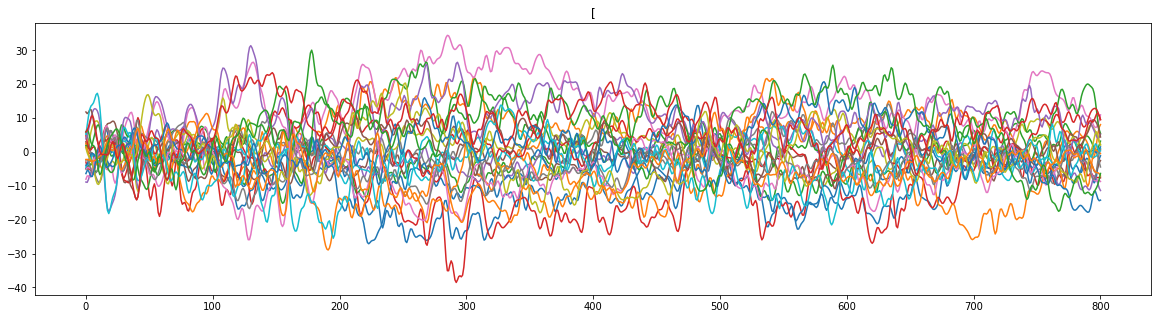

In [13]:
#plot a sample
eeg, label = next(iter(train_loader))
fig = plt.figure(figsize=(20, 5))
print(label)
print(eeg.shape)
plt.title(get_letter(label[0] + 1))
for curve in eeg.to('cpu')[0]:
    plt.plot(curve)

# 1D CNN

In [14]:
momentum = 0.4
track_running_stats = True
affine = True
class NetCNN(nn.Module):
    def __init__(self, channels_in=24, channels_out=26):
        super().__init__()

        self.seq = nn.Sequential(
            nn.Conv1d(channels_in, 16, 1, padding=0),
            nn.BatchNorm1d(16, momentum=momentum, track_running_stats=track_running_stats, affine=affine),
            nn.ReLU(),
            nn.Conv1d(16, 32, 5, stride=3, padding=0),
            nn.BatchNorm1d(32, momentum=momentum, track_running_stats=track_running_stats, affine=affine),
            nn.ReLU(),
            nn.MaxPool1d(4, stride=2),
            nn.Conv1d(32, 64, 5, stride=2, padding=0),
            nn.BatchNorm1d(64, momentum=momentum, track_running_stats=track_running_stats, affine=affine),
            nn.ReLU(),
            nn.MaxPool1d(4, stride=2),
            nn.Conv1d(64, 48, 5, stride=2, padding=0),
            nn.BatchNorm1d(48, momentum=momentum, track_running_stats=track_running_stats, affine=affine),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(14 * 48, 80),
            nn.ReLU(),
            nn.Linear(80, channels_out)
        )
        
    def forward(self, x):
        x = self.seq(x)
        return x

In [15]:
#create the model and input a sample
data_type = eeg[0][0].dtype
net = NetCNN(channels_in=24, channels_out=26).to(device, data_type)
print(eeg.shape)
net(eeg)[1]

torch.Size([4, 24, 801])


tensor([ 0.2437,  0.2130, -0.2078, -0.0575,  0.0048, -0.0203,  0.0034,  0.1205,
         0.0510, -0.0264,  0.0786,  0.0118,  0.0068, -0.1491,  0.1034,  0.0721,
        -0.1038,  0.0615,  0.2426,  0.2499,  0.2255,  0.1949,  0.2895, -0.1348,
         0.0924, -0.0154], device='cuda:0', dtype=torch.float64,
       grad_fn=<SelectBackward0>)

# Train

[33, 16, 11, 8, 6, 5, 4, 4, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 33, 16, 11, 8, 6, 5, 4, 4, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 33, 16, 11, 8, 6, 5, 4, 4, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 33, 16, 11, 8, 6, 5, 4, 4, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 33, 16, 11, 8, 6, 5, 4, 4, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1]


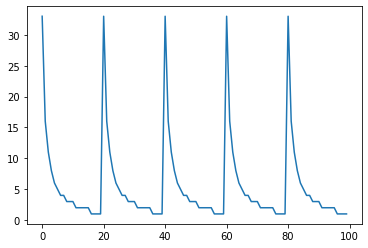

In [16]:
height = 100
steep = 3
def avr(height, steep, i):
    return np.max((round(height // (steep * (1 + i % 20))), 1))

#plot the curve of average numbers
plt.plot([avr(height, steep, i) for i in range (0, 100)])
#plt.plot([max(1, 30 - (i  % 20) * 3) for i in range (0, 100)])
print([avr(height, steep, i) for i in range (0, 100)])

In [17]:
def TrainClassifer(model,trn_data,val_dl,optimizer, scheduler=None,
                   n_eopchs=20, device='cpu'):
    #trn_dl isn't used here, the train dataloader is built inside the loop
    loss_fn = nn.CrossEntropyLoss()
    model.to(device)
    best_val = 999.0
    best_acc = 0.0
    metric = np.empty((0, 2), np.float32)

    for epoch in range(0, n_eopchs):
        loss_train = 0.0
        model.train()
        
        #train
        # build a new dataset and dataloader
        trainset = EEGdataset(trn_data, data_labels, avr(height, steep, epoch), device)
        trn_loader = DataLoader(trainset, batch_size = batch_size, shuffle=True)
        
        for imgs, labels in trn_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            #outputs = model(imgs.unsqueeze(1))
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
            
        #validation
        loss_val = 0.0
        correct_val = 0.0
        model.eval()
        for _, (imgs, labels) in enumerate(val_dl):
            imgs = imgs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                outputs = model(imgs)
                #outputs = model(imgs.unsqueeze(1))
                loss = loss_fn(outputs, labels)
                loss_val += loss.item()
                
                correct_val += torch.sum(torch.argmax(outputs, dim=1) == labels)
                
        # record the best accuracy/loss and save the model for best accuracy and best loss
        t_val_loss = (loss_val / len(val_dl))
        if  t_val_loss < best_val:
            best_val = t_val_loss
            torch.save(model.state_dict(), './best_val.pt')
            
        t_val_acc = (100 * correct_val / (len(val_dl) * val_dl.batch_size)).to('cpu').item()
        if t_val_acc > best_acc:
            best_acc = t_val_acc
            torch.save(model.state_dict(), './best_acc.pt')
            
        if scheduler != None:
            scheduler.step()

        print('{} Eopch {}, Training Loss {}, Val Loss {}, Val Accuracy {}'.format(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime()),
                                                                  epoch, loss_train / len(trn_loader), t_val_loss, 
                                                                                   t_val_acc))

        metric = np.append(metric, np.array([t_val_loss, t_val_acc]).reshape(1, 2), axis=0)
        
    print('Finish training: best_val:{} best_acc:{}'.format(best_val, best_acc))
    return metric, best_acc

In [18]:
kfold_metric = np.empty((0, 100, 2), np.float32)
kfold_acc = np.array([])
for k in range(0, 5):
    train_data, val_data = split_data(ref_data, idx_kfold, k)
    eegvalset = EEGdataset(val_data, val_labels, 1, device)
    val_loader = DataLoader(eegvalset, batch_size = batch_size, shuffle=True)
    net = NetCNN(channels_in=24, channels_out=26).to(device, data_type)
    optimizer = optim.SGD(net.parameters(), lr=2e-3)
    
    metric, best_acc = TrainClassifer(net, train_data, val_loader, optimizer, scheduler=None,
                                      n_eopchs=100, device=device)
    kfold_metric = np.concatenate([kfold_metric, metric.reshape(1, -1, 2)], axis=0)
    kfold_acc = np.append(kfold_acc, best_acc)

2022-09-25 14:09:53 Eopch 0, Training Loss 2.9444452275524897, Val Loss 6.787749313554562, Val Accuracy 4.871795177459717
2022-09-25 14:10:03 Eopch 1, Training Loss 2.2102310699579872, Val Loss 6.406491252860233, Val Accuracy 6.987179756164551
2022-09-25 14:10:13 Eopch 2, Training Loss 1.6122852553897538, Val Loss 6.789885659290103, Val Accuracy 7.179487228393555
2022-09-25 14:10:21 Eopch 3, Training Loss 1.4580224812062414, Val Loss 6.657478059606427, Val Accuracy 7.628205299377441
2022-09-25 14:10:29 Eopch 4, Training Loss 1.4795143687053243, Val Loss 5.753265978867536, Val Accuracy 9.102564811706543
2022-09-25 14:10:37 Eopch 5, Training Loss 1.4902975269432726, Val Loss 5.611855545605694, Val Accuracy 9.423077583312988
2022-09-25 14:10:45 Eopch 6, Training Loss 1.6101802536672256, Val Loss 4.932168511479935, Val Accuracy 10.19230842590332
2022-09-25 14:10:52 Eopch 7, Training Loss 1.5184057624438336, Val Loss 4.7335447829806565, Val Accuracy 10.64102554321289
2022-09-25 14:11:00 Eop

In [19]:
print("Result of k-fold cross validation:")
for k in range(0, 5):
    print("Best Accuracy for Fold {}: {}".format(k, kfold_acc[k]))
print("Best Accuracy in total: {}".format(np.max(kfold_acc)))

Result of k-fold cross validation:
Best Accuracy for Fold 0: 14.679487228393555
Best Accuracy for Fold 1: 15.512821197509766
Best Accuracy for Fold 2: 15.641026496887207
Best Accuracy for Fold 3: 15.70512866973877
Best Accuracy for Fold 4: 16.346155166625977
Best Accuracy in total: 16.346155166625977


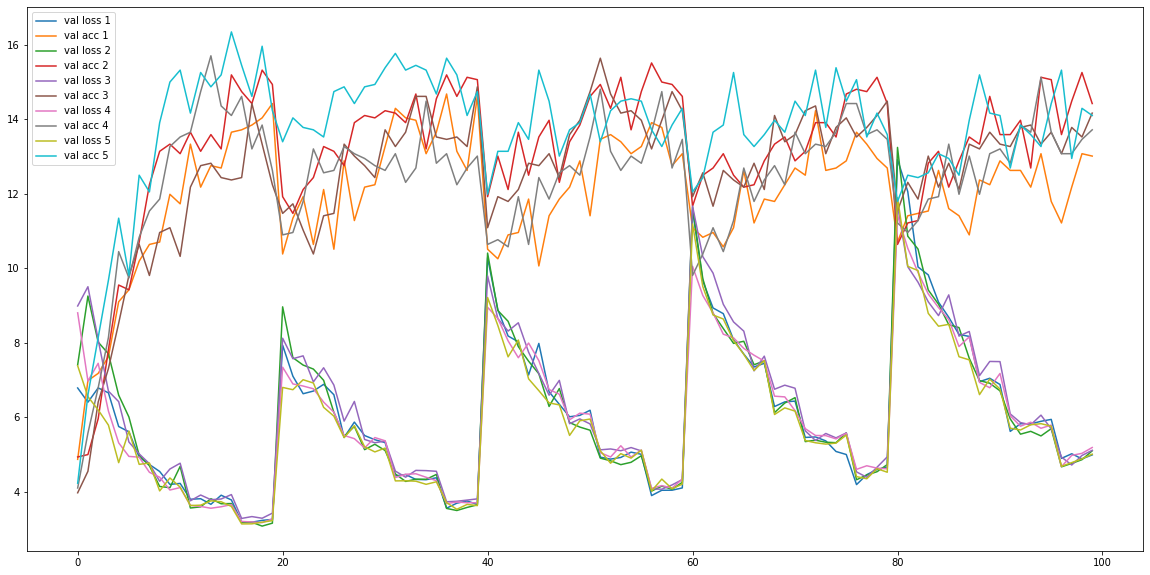

In [20]:
plt.figure(figsize=(20,10))
legend = ['val loss 1', 'val acc 1',
          'val loss 2', 'val acc 2',
          'val loss 3', 'val acc 3',
          'val loss 4', 'val acc 4',
          'val loss 5', 'val acc 5']
for i in range(0, 5):
    for j in range(0, 2):
        plt.plot(kfold_metric[i, :, j], label = legend[i*2 + j])
plt.legend()